In [1]:
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd

from shapely.geometry import Point

from datetime import datetime

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import weibull_min
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.optimize import differential_evolution

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from playsound import playsound

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import wei_fit_update, fit_yearly_weibull_update, compute_beta, str_exp_fun, epl_fun, myfun_sse, down_wei, down_wei_beta_alpha
from ART_preprocessing import haversine, create_box, space_time_scales_agregations, wet_matrix_extrapolation, autocorrelation_neighborhood, area_lat_lon, spatial_correlation
from ART_plot import plot_neighborhood, plot_scales_aggregation, plot_wet_fraction_matrix, plot_autocorrelation, plot_scatter

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
corr_method = 'pearson'
# corr_method = 'spearman'

target_t = 24
threshold = 1

In [3]:
# name, yy_s, yy_e = 'Coast Level', 2001, 2017
# name, yy_s, yy_e = 'Low Level', 2001, 2014
# name, yy_s, yy_e = 'Medium Level', 2001, 2017
name, yy_s, yy_e = 'High Level', 2001, 2022

maxmiss = 100

In [4]:
npix = 5 # each pixel is 10 km, with odd number the center is simetric (3, 5, 7 and 9)

# thresh = 1 # default
thresh = 1
# thresh = 2.6 
# thresh = 3
# thresh = 4 

# thresh_OBS = 0.1
thresh_OBS = 1

res = {} # Output dictionary with all information

In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [6]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31.nc')

if os.path.exists(data_dir):
    DATA = xr.open_dataset(data_dir)
    DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
else:
    raise SystemExit(f"File not found: {data_dir}")

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

DATES = DATA['time'][:]

DATA

<xarray.Dataset> Size: 618MB
Dimensions:  (time: 64280, lat: 30, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 514kB 2001-01-01 ... 2022-12-31T21:00:00
  * lat      (lat) float32 120B 44.05 44.15 44.25 44.35 ... 46.75 46.85 46.95
  * lon      (lon) float32 160B 10.05 10.15 10.25 10.35 ... 13.75 13.85 13.95
Data variables:
    PRE      (time, lat, lon) float64 617MB ...
Attributes:
    description:  IMERG 3 hour data for Veneto region

In [7]:
OBS_base = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'VENETO_INFO_1dy.csv')

if os.path.exists(OBS_INFO_dir):
    RAIN = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

if name == 'Coast Level':
    Id_station = '338_RO_Co'
elif name == 'Low Level':
    Id_station = '274_VR_Mo'
elif name == 'Medium Level':
    Id_station = '343_BL_Fo'
elif name == 'High Level':
    Id_station = '348_NP_Ro'
else:
    print('ERROR: Id dont found')

CL_INFO = RAIN[RAIN['File_Name']==Id_station]

elevation = CL_INFO['Elv'].values[0]

CL_RAIN = pd.read_csv(os.path.join(OBS_base, 'CLEAR_1dy', f'{CL_INFO['File_Name'].values[0]}.csv'), sep=',')
CL_RAIN['TIME'] = pd.to_datetime(CL_RAIN['TIME'].values)
CL_RAIN = CL_RAIN[(CL_RAIN['TIME'].dt.year >= yy_s) & (CL_RAIN['TIME'].dt.year <= yy_e)]

OBS_xr = xr.DataArray(CL_RAIN['PRE'].values,  coords={'time':CL_RAIN['TIME'].values}, dims=('time'))

print(f'{name} station ({elevation} m)')

High Level station (1160 m)


In [8]:
distances = haversine(lat2d, lon2d, CL_INFO['Lat'].values[0],CL_INFO['Lon'].values[0])

min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

clat = lats[min_index[0]]
clon = lons[min_index[1]]

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {CL_INFO['Lat'].values[0]}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {CL_INFO['Lon'].values[0]}')

Nearest IMERG lat: 46.14999771118164
Station lat       : 46.19073266

Nearest IMERG lon: 12.449999809265137
Station lon       : 12.40789032


In [9]:
box_3h, bcond = create_box(DATA, clat, clon, npix, reso=0.1)

box_lon2d, box_lat2d = np.meshgrid(box_3h['lon'].data, box_3h['lat'].data)

print(f'Dimension of box3d: {box_3h.shape}')

Dimension of box3d: (5, 5, 64280)


In [10]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
data_dir =  os.path.join(dir_base,'VENETO_INFO_1dy.csv')
VENETO_INFO_1dy = pd.read_csv(data_dir)

In [11]:
radius = 35

center = Point(clon, clat)
circle = center.buffer(radius / 111.32) 
gdf = gpd.GeoDataFrame(geometry=[circle], crs="EPSG:4326")

veneto_gdf = gpd.GeoDataFrame(
    VENETO_INFO_1dy,
    geometry=gpd.points_from_xy(VENETO_INFO_1dy["Lon"], VENETO_INFO_1dy["Lat"]),
    crs="EPSG:4326"
)

points_within_circle = veneto_gdf[veneto_gdf.geometry.within(circle)]
points_within_circle.reset_index(inplace=True)

In [22]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
CORR = spatial_correlation(points_within_circle, threshold, dir_base, corr_method).dropna()
CORR = CORR[CORR['corr']>0.5] # Becarful with this limit

FIT, _ = curve_fit(epl_fun, CORR['dist'].values, CORR['corr'].values)
CORR_eps, CORR_alp = FIT

In [23]:
vdist, vcorr, distance_vector = autocorrelation_neighborhood(box_3h, t_target=target_t, thresh=thresh, cor_method = corr_method)

FIT, _ = curve_fit(epl_fun, vdist, vcorr)
FIT_eps, FIT_alp = FIT

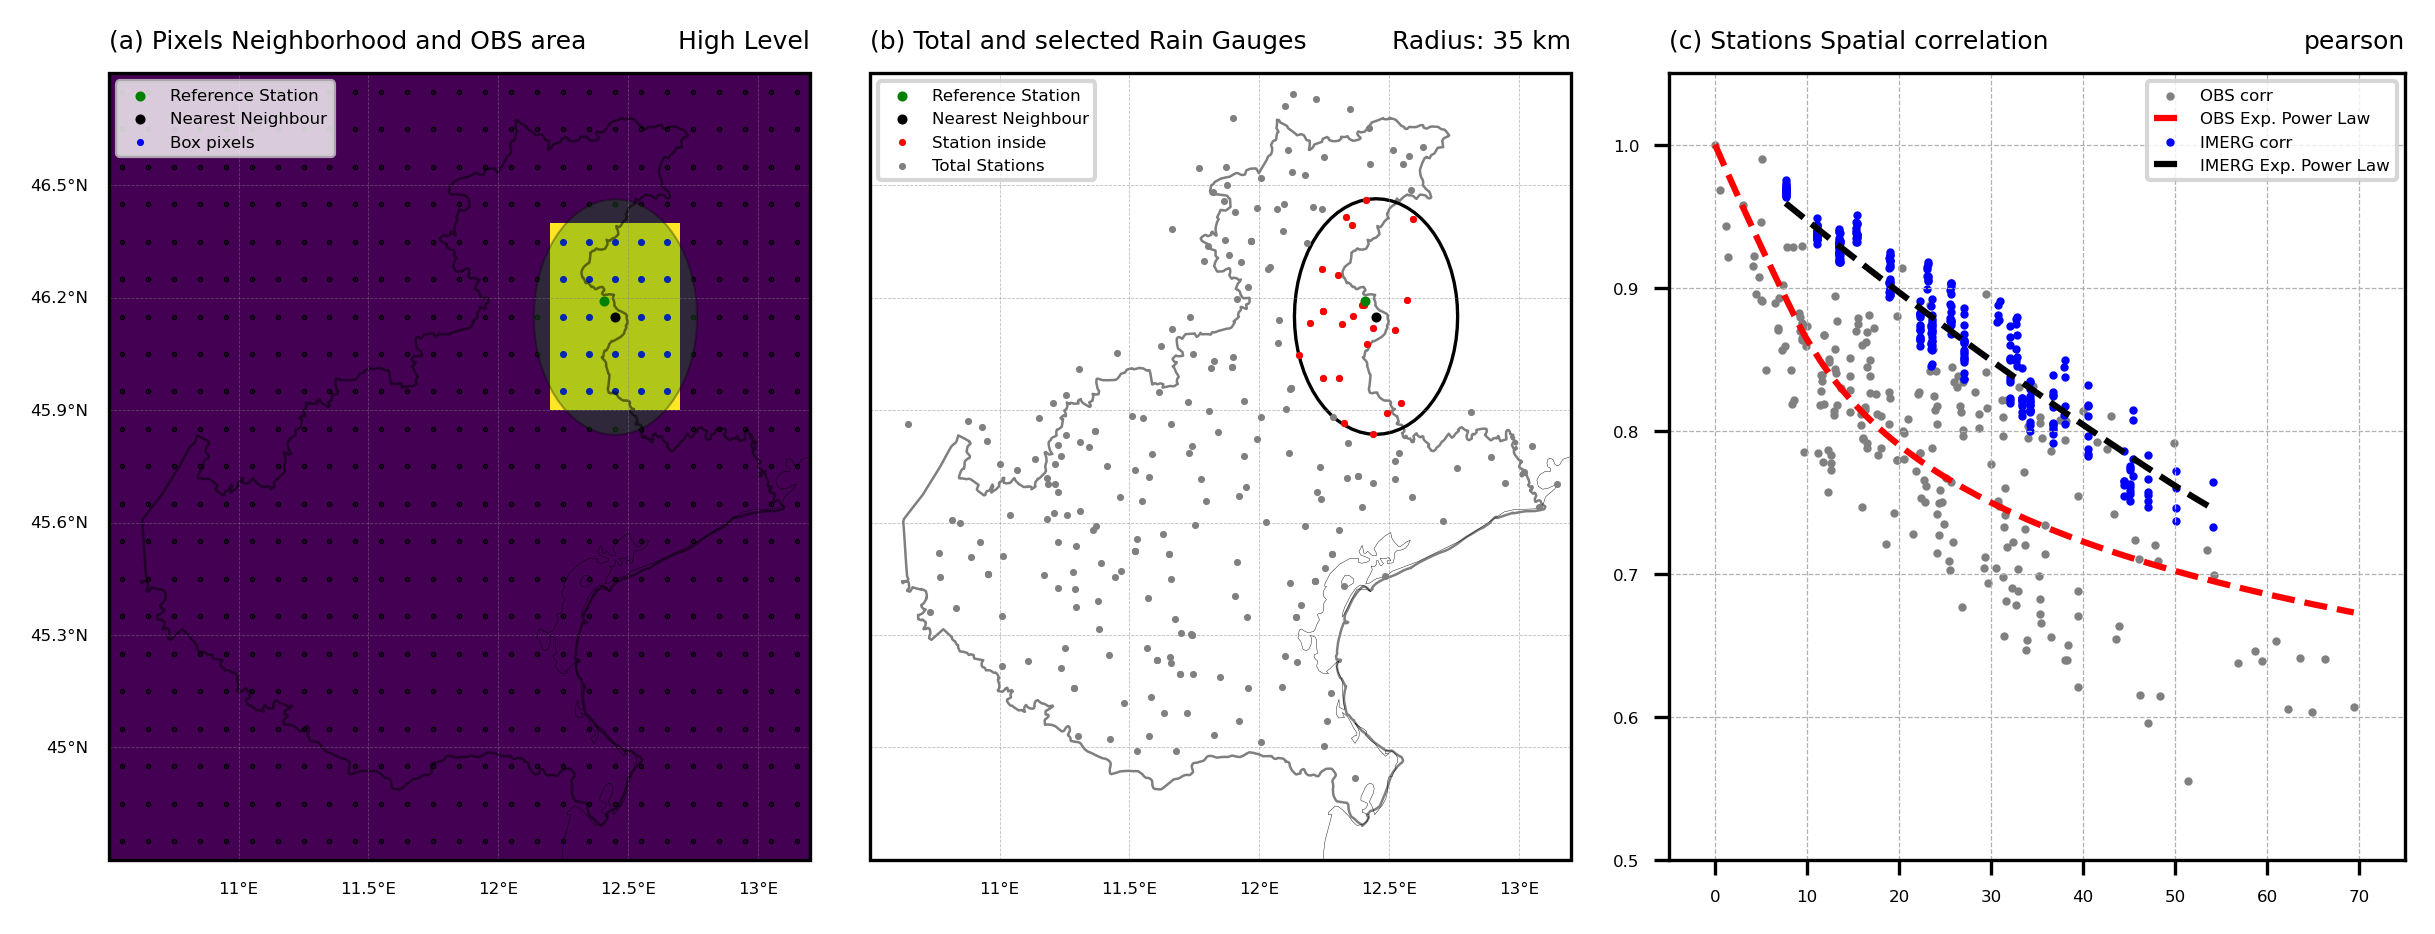

In [24]:
cmap_bin = plt.get_cmap('viridis', 3)  # Use any colormap you like with 2 discrete levels
norm = mcolors.BoundaryNorm([0, 0.5, 1], cmap_bin.N)  

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,3),dpi=300, constrained_layout=True)
gs = gridspec.GridSpec(1,3, figure=fig)

# ========================================================================================
ax2 = fig.add_subplot(gs[0, 0], projection=proj)
ax2.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax2.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax2.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)
a1 = ax2.pcolormesh(lon2d, lat2d, bcond, cmap=cmap_bin, norm=norm)

ax2.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')
ax2.scatter(CL_INFO['Lon'].values[0], CL_INFO['Lat'].values[0], s=2, c='g', zorder=10, label='Reference Station')
ax2.scatter(clon, clat, s=2, c='k', zorder=10, label='Nearest Neighbour')
ax2.scatter(box_lon2d, box_lat2d, s=0.5, c='b', label='Box pixels')

gdf.plot(ax=ax2, linewidth=0.5, facecolor='g', edgecolor='k', alpha=0.3)

plt.legend(fontsize=4, loc=2)

gl = ax2.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax2.set_title('(a) Pixels Neighborhood and OBS area', loc='left', fontsize=6)
ax2.set_title(name, loc='right', fontsize=6)

# ========================================================================================
ax3 = fig.add_subplot(gs[0, 1], projection=proj)
ax3.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax3.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax3.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

ax3.scatter(CL_INFO['Lon'].values[0], CL_INFO['Lat'].values[0], s=2, c='g', zorder=20, label='Reference Station')
ax3.scatter(clon, clat, s=2, c='k', zorder=10, label='Nearest Neighbour')

ax3.scatter(points_within_circle['Lon'], points_within_circle['Lat'], s=0.5, c='r', zorder=10, label='Station inside' )
ax3.scatter(VENETO_INFO_1dy['Lon'], VENETO_INFO_1dy['Lat'], s=0.5, c='grey', zorder=8, label='Total Stations')

gdf.plot(ax=ax3, linewidth=0.8, facecolor='none', edgecolor='k')

plt.legend(fontsize=4, loc=2)

gl = ax3.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax3.set_title('(b) Total and selected Rain Gauges', loc='left', fontsize=6)
ax3.set_title(f'Radius: {radius} km', loc='right', fontsize=6)

# ========================================================================================
ax1 = fig.add_subplot(gs[0, 2])

ax1.scatter(CORR['dist'].values, CORR['corr'].values, s=1, color='grey', label='OBS corr')
ax1.plot(CORR['dist'].values, epl_fun(CORR['dist'].values, CORR_eps, CORR_alp), '--r', label='OBS Exp. Power Law')
# ax1.axvline(x=CORR_eps, color='k', linestyle='--', linewidth=0.4, label=f'eps: {np.round(CORR_eps,3)}')

xx = np.linspace(np.min(vdist), np.max(vdist), 100)
ax1.scatter(vdist, vcorr, s=1, color='b', label='IMERG corr')
ax1.plot(xx, epl_fun(xx, FIT_eps, FIT_alp), '--k', label='IMERG Exp. Power Law')

plt.legend(fontsize=4, loc=1)

ax1.xaxis.set_tick_params(labelsize=4)
ax1.yaxis.set_tick_params(labelsize=4)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(c) Stations Spatial correlation', loc='left', fontsize=6)
ax1.set_title(f'{corr_method}', loc='right', fontsize=6)

ax1.set_xlim(-5,75)
ax1.set_ylim(0.5,1.05)

# ========================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

image_dir = f'/home/arturo/github/downpy/fig/corr/corr_{corr_method}_{name}.png'
# plt.savefig(image_dir,transparent = False,bbox_inches ='tight',pad_inches = 0.01)